# Chapter 04: Multi-Series Fitting Caveats

In Chapter 03, we demonstrated how vangja's simultaneous fitting provides equivalent results to sequential fitting when series share the **same time range**. But what happens when series have **different date ranges**?

This notebook explores the caveats and gotchas that arise when fitting series with non-overlapping time ranges, using real-world datasets as examples.

**Key takeaways:**
- Changepoints are distributed across the combined time range
- Series with different date ranges may get fewer changepoints than expected
- Use `filter_predictions_by_series()` to filter predictions to each series' date range
- Consider fitting series with similar date ranges together

## Setup and Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vangja import LinearTrend, FourierSeasonality
from vangja.utils import metrics, filter_predictions_by_series

print("Imports successful!")

Imports successful!


## Load Real-World Datasets

We'll use two classic datasets with **very different date ranges**:
- **Air Passengers**: Monthly airline passengers, 1949-1960 (12 years ago!)
- **Peyton Manning Wikipedia Views**: Daily page views, 2007-2016

In [ ]:
# Load Air Passengers dataset (1949-1960)
url_passengers = "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv"
air_passengers = pd.read_csv(url_passengers)
air_passengers["ds"] = pd.to_datetime(air_passengers["ds"])
air_passengers["series"] = "air_passengers"

# Load Peyton Manning dataset (2007-2016)
url_peyton = "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"
peyton_manning = pd.read_csv(url_peyton)
peyton_manning["ds"] = pd.to_datetime(peyton_manning["ds"])
peyton_manning["series"] = "peyton_manning"

print(
    f"Air Passengers: {air_passengers['ds'].min().date()} to {air_passengers['ds'].max().date()} ({len(air_passengers)} samples, monthly)"
)
print(
    f"Peyton Manning: {peyton_manning['ds'].min().date()} to {peyton_manning['ds'].max().date()} ({len(peyton_manning)} samples, daily)"
)

Air Passengers: 1949-01-01 to 1960-12-01 (144 samples, monthly)
Peyton Manning: 2007-12-10 to 2016-01-20 (2905 samples, daily)


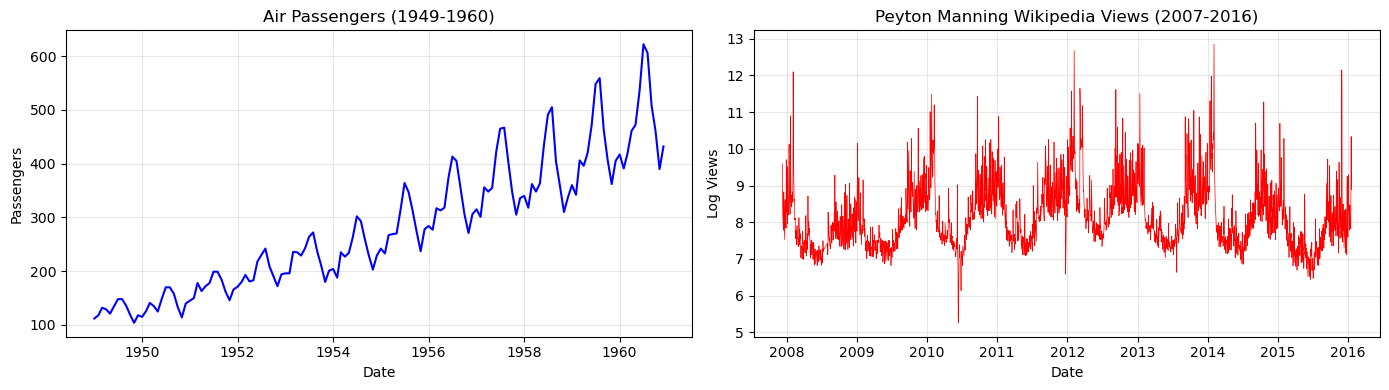


Time gap between series: 17175 days (~47 years!)


In [ ]:
# Visualize the date ranges
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(air_passengers["ds"], air_passengers["y"], "b-")
axes[0].set_title("Air Passengers (1949-1960)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Passengers")
axes[0].grid(True, alpha=0.3)

axes[1].plot(peyton_manning["ds"], peyton_manning["y"], "r-", linewidth=0.5)
axes[1].set_title("Peyton Manning Wikipedia Views (2007-2016)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Log Views")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(
    f"\nTime gap between series: {(peyton_manning['ds'].min() - air_passengers['ds'].max()).days} days (~47 years!)"
)

## Understanding the Caveat: Changepoint Distribution

**The problem**: When fitting multiple series simultaneously, vangja normalizes time to `t = [0, 1]` across the **entire combined time range**. This has two important consequences:

1. **Time compression**: Each series occupies only a small portion of the normalized time range
2. **Changepoint dilution**: The `n_changepoints` are distributed across the full range, so each series may get very few changepoints in its actual date range

Let's visualize this:

In [ ]:
# Calculate normalized time ranges
combined_min = min(air_passengers["ds"].min(), peyton_manning["ds"].min())
combined_max = max(air_passengers["ds"].max(), peyton_manning["ds"].max())
combined_range_days = (combined_max - combined_min).days

# Air Passengers normalized range
ap_t_min = (air_passengers["ds"].min() - combined_min).days / combined_range_days
ap_t_max = (air_passengers["ds"].max() - combined_min).days / combined_range_days

# Peyton Manning normalized range
pm_t_min = (peyton_manning["ds"].min() - combined_min).days / combined_range_days
pm_t_max = (peyton_manning["ds"].max() - combined_min).days / combined_range_days

print(
    f"Combined time range: {combined_min.date()} to {combined_max.date()} ({combined_range_days} days, ~{combined_range_days/365:.1f} years)"
)
print("\nNormalized t = [0, 1] distribution:")
print(
    f"  Air Passengers: t = [{ap_t_min:.3f}, {ap_t_max:.3f}] (only {(ap_t_max - ap_t_min)*100:.1f}% of range)"
)
print(
    f"  Peyton Manning: t = [{pm_t_min:.3f}, {pm_t_max:.3f}] (only {(pm_t_max - pm_t_min)*100:.1f}% of range)"
)

# Estimate changepoints per series with n_changepoints=25
n_changepoints = 25
ap_expected_cp = (
    n_changepoints * (ap_t_max - ap_t_min) * 0.8
)  # 80% of data for changepoints
pm_expected_cp = n_changepoints * (pm_t_max - pm_t_min) * 0.8

print(f"\nWith n_changepoints={n_changepoints} distributed across combined range:")
print(
    f"  Air Passengers: ~{ap_expected_cp:.1f} changepoints expected (vs 25 if fit separately)"
)
print(
    f"  Peyton Manning: ~{pm_expected_cp:.1f} changepoints expected (vs 25 if fit separately)"
)

Combined time range: 1949-01-01 to 2016-01-20 (24490 days, ~67.1 years)

Normalized t = [0, 1] distribution:
  Air Passengers: t = [0.000, 0.178] (only 17.8% of range)
  Peyton Manning: t = [0.879, 1.000] (only 12.1% of range)

With n_changepoints=25 distributed across combined range:
  Air Passengers: ~3.6 changepoints expected (vs 25 if fit separately)
  Peyton Manning: ~2.4 changepoints expected (vs 25 if fit separately)


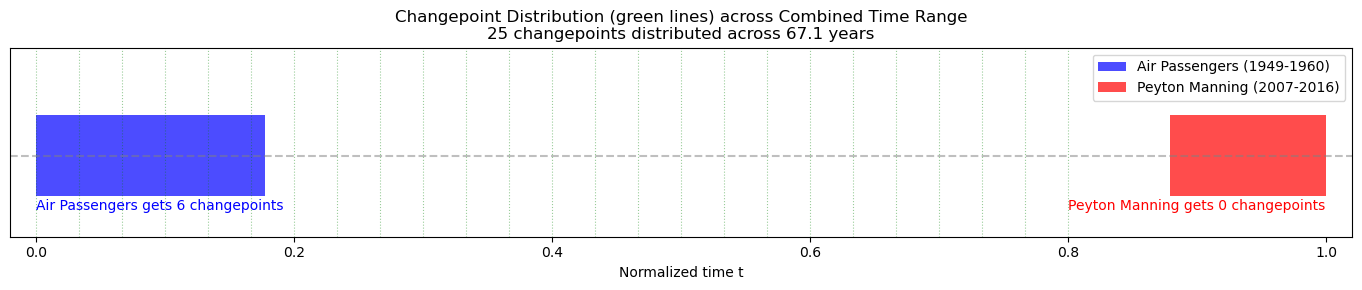

In [25]:
# Visualize the time normalization issue
fig, ax = plt.subplots(figsize=(14, 3))

# Draw the normalized time range [0, 1]
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)

# Air Passengers range
ax.barh(
    0,
    ap_t_max - ap_t_min,
    left=ap_t_min,
    height=0.3,
    color="blue",
    alpha=0.7,
    label="Air Passengers (1949-1960)",
)

# Peyton Manning range
ax.barh(
    0,
    pm_t_max - pm_t_min,
    left=pm_t_min,
    height=0.3,
    color="red",
    alpha=0.7,
    label="Peyton Manning (2007-2016)",
)

# Changepoints (evenly distributed)
changepoint_positions = np.linspace(0, 0.8, n_changepoints)  # Default is 80% of range
for cp in changepoint_positions:
    ax.axvline(x=cp, color="green", linestyle=":", alpha=0.4, linewidth=0.8)

ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.3, 0.4)
ax.set_xlabel("Normalized time t")
ax.set_yticks([])
ax.set_title(
    f"Changepoint Distribution (green lines) across Combined Time Range\n{n_changepoints} changepoints distributed across {combined_range_days/365:.1f} years"
)
ax.legend(loc="upper right")

# Count changepoints in each series range
cp_in_ap = sum(1 for cp in changepoint_positions if ap_t_min <= cp <= ap_t_max)
cp_in_pm = sum(1 for cp in changepoint_positions if pm_t_min <= cp <= pm_t_max)
ax.text(
    0,
    -0.2,
    f"Air Passengers gets {cp_in_ap} changepoints",
    fontsize=10,
    color="blue",
)
ax.text(
    0.8, -0.2, f"Peyton Manning gets {cp_in_pm} changepoints", fontsize=10, color="red"
)

plt.tight_layout()
plt.show()

## Demonstrating the Impact

Let's fit both series using:
1. **Sequential fitting**: Each series fit independently (baseline)
2. **Simultaneous fitting**: Both series fit together

In [ ]:
# Prepare train/test splits
# Air Passengers: hold out last 24 months (monthly data)
train_passengers = air_passengers[:-24].copy()
test_passengers = air_passengers[-24:].copy()

# Peyton Manning: hold out last 365 days (daily data)
train_peyton = peyton_manning[:-365].copy()
test_peyton = peyton_manning[-365:].copy()

# Combined training data
train_combined = pd.concat([train_passengers, train_peyton], ignore_index=True)

print(
    f"Air Passengers training: {len(train_passengers)} months, test: {len(test_passengers)} months"
)
print(
    f"Peyton Manning training: {len(train_peyton)} days, test: {len(test_peyton)} days"
)

Air Passengers training: 120 months, test: 24 months
Peyton Manning training: 2540 days, test: 365 days


### Sequential Fitting (Baseline)

In [ ]:
# Fit Air Passengers sequentially
model_passengers_seq = LinearTrend(n_changepoints=25) + FourierSeasonality(
    period=12, series_order=5
)  # Yearly seasonality (monthly data)

start_time = time.time()
model_passengers_seq.fit(train_passengers, method="mapx")
time_passengers_seq = time.time() - start_time

print(f"Air Passengers sequential fit: {time_passengers_seq:.2f}s")

Output()

Air Passengers sequential fit: 3.47s


In [ ]:
# Fit Peyton Manning sequentially
model_peyton_seq = (
    LinearTrend(n_changepoints=25)
    + FourierSeasonality(
        period=365.25, series_order=10
    )  # Yearly seasonality (daily data)
    + FourierSeasonality(period=7, series_order=3)  # Weekly seasonality
)

start_time = time.time()
model_peyton_seq.fit(train_peyton, method="mapx")
time_peyton_seq = time.time() - start_time

print(f"Peyton Manning sequential fit: {time_peyton_seq:.2f}s")
print(f"Total sequential time: {time_passengers_seq + time_peyton_seq:.2f}s")

Output()

Peyton Manning sequential fit: 3.42s
Total sequential time: 6.89s


In [14]:
# Sequential predictions and metrics
future_passengers_seq = model_passengers_seq.predict(horizon=365, freq="D")  # Monthly
future_peyton_seq = model_peyton_seq.predict(horizon=365, freq="D")  # Daily

metrics_passengers_seq = metrics(test_passengers, future_passengers_seq, "complete")
metrics_peyton_seq = metrics(test_peyton, future_peyton_seq, "complete")

print("Sequential Fitting Metrics:")
print(f"Air Passengers:")
display(metrics_passengers_seq)
print(f"Peyton Manning:")
display(metrics_peyton_seq)

Sequential Fitting Metrics:
Air Passengers:


,mse,rmse,mae,mape
air_passengers,4277.957951,65.4061,49.547352,0.109501


Peyton Manning:


,mse,rmse,mae,mape
peyton_manning,0.295666,0.543751,0.423117,0.054523


### Simultaneous Fitting

In [ ]:
# Create model for simultaneous fitting
# Note: We use individual pooling and a common seasonality order that works for both
model_combined = LinearTrend(
    n_changepoints=25, pool_type="individual"
) + FourierSeasonality(
    period=365.25, series_order=10, pool_type="individual"
)  # Yearly

start_time = time.time()
model_combined.fit(train_combined, method="mapx", scale_mode="individual")
time_combined = time.time() - start_time

print(f"Simultaneous fitting time: {time_combined:.2f}s")
print(f"Group mapping: {model_combined.groups_}")

Output()

Simultaneous fitting time: 13.02s
Group mapping: {0: 'air_passengers', 1: 'peyton_manning'}


In [ ]:
# Generate predictions
# The prediction spans the entire combined time range plus horizon!
future_combined = model_combined.predict(horizon=365, freq="D")

print(
    f"Combined prediction date range: {future_combined['ds'].min().date()} to {future_combined['ds'].max().date()}"
)
print(f"That's {len(future_combined)} rows!")
print(
    f"\nPrediction columns: {[col for col in future_combined.columns if 'yhat' in col]}"
)

Combined prediction date range: 1949-01-01 to 2016-01-18
That's 24489 rows!

Prediction columns: ['yhat_0', 'yhat_1']


### Using `filter_predictions_by_series()`

When fitting series with different date ranges, predictions span the entire combined time range. Use `filter_predictions_by_series()` to get predictions for each series' relevant date range:

In [17]:
# Get group codes
group_mapping = model_combined.groups_
passengers_group = [k for k, v in group_mapping.items() if v == "air_passengers"][0]
peyton_group = [k for k, v in group_mapping.items() if v == "peyton_manning"][0]

print(f"Air Passengers group: {passengers_group}")
print(f"Peyton Manning group: {peyton_group}")

Air Passengers group: 0
Peyton Manning group: 1


In [ ]:
# Filter predictions for Air Passengers
# Note: horizon is in DAYS, so for 24 months we need ~730 days
future_passengers_combined = filter_predictions_by_series(
    future=future_combined,
    series_data=train_passengers,
    yhat_col=f"yhat_{passengers_group}",
    horizon=24 * 31,  # 24 months ≈ 744 days
)

# Filter predictions for Peyton Manning
future_peyton_combined = filter_predictions_by_series(
    future=future_combined,
    series_data=train_peyton,
    yhat_col=f"yhat_{peyton_group}",
    horizon=365,  # 365 days
)

print(f"Filtered Air Passengers predictions: {len(future_passengers_combined)} rows")
print(
    f"  Date range: {future_passengers_combined['ds'].min().date()} to {future_passengers_combined['ds'].max().date()}"
)
print(f"\nFiltered Peyton Manning predictions: {len(future_peyton_combined)} rows")
print(
    f"  Date range: {future_peyton_combined['ds'].min().date()} to {future_peyton_combined['ds'].max().date()}"
)

Filtered Air Passengers predictions: 4366 rows
  Date range: 1949-01-01 to 1960-12-14

Filtered Peyton Manning predictions: 2962 rows
  Date range: 2007-12-10 to 2016-01-18


In [ ]:
# Calculate metrics using filtered predictions
# Note: Need to rename column to yhat_0 for metrics() function
future_passengers_for_metrics = future_passengers_combined.rename(
    columns={f"yhat_{passengers_group}": "yhat_0"}
)
future_peyton_for_metrics = future_peyton_combined.rename(
    columns={f"yhat_{peyton_group}": "yhat_0"}
)

metrics_passengers_combined = metrics(
    test_passengers, future_passengers_for_metrics, "complete"
)
metrics_peyton_combined = metrics(test_peyton, future_peyton_for_metrics, "complete")

print("Simultaneous Fitting Metrics:")
print(f"\nAir Passengers:")
display(metrics_passengers_combined)
print(f"\nPeyton Manning:")
display(metrics_peyton_combined)

Simultaneous Fitting Metrics:

Air Passengers:


,mse,rmse,mae,mape
air_passengers,2220.774133,47.12509,34.117695,0.067933



Peyton Manning:


,mse,rmse,mae,mape
peyton_manning,0.889813,0.943299,0.865427,0.113608


## Comparison: Sequential vs Simultaneous

Let's compare the metrics side-by-side to see the impact of changepoint dilution:

In [ ]:
# Create comparison table
comparison_data = []

for series_name, seq_metrics, sim_metrics in [
    ("Air Passengers", metrics_passengers_seq, metrics_passengers_combined),
    ("Peyton Manning", metrics_peyton_seq, metrics_peyton_combined),
]:
    comparison_data.append(
        {
            "Series": series_name,
            "Approach": "Sequential",
            "RMSE": seq_metrics["rmse"].values[0],
            "MAE": seq_metrics["mae"].values[0],
            "MAPE": seq_metrics["mape"].values[0],
        }
    )
    comparison_data.append(
        {
            "Series": series_name,
            "Approach": "Simultaneous",
            "RMSE": sim_metrics["rmse"].values[0],
            "MAE": sim_metrics["mae"].values[0],
            "MAPE": sim_metrics["mape"].values[0],
        }
    )

metrics_comparison = pd.DataFrame(comparison_data)
print("Metrics Comparison:")
display(metrics_comparison)

Metrics Comparison:


,Series,Approach,RMSE,MAE,MAPE
0,Air Passengers,Sequential,65.406100,49.547352,0.109501
1,Air Passengers,Simultaneous,47.125090,34.117695,0.067933
2,Peyton Manning,Sequential,0.543751,0.423117,0.054523
3,Peyton Manning,Simultaneous,0.943299,0.865427,0.113608


In [22]:
future_peyton_combined

,ds,yhat_0
0,2007-12-10,8.318976
1,2007-12-11,8.307713
2,2007-12-12,8.297031
3,2007-12-13,8.287280
4,2007-12-14,8.278780
...,...,...
2957,2016-01-14,9.462423
2958,2016-01-15,9.493212
2959,2016-01-16,9.523955
2960,2016-01-17,9.554402


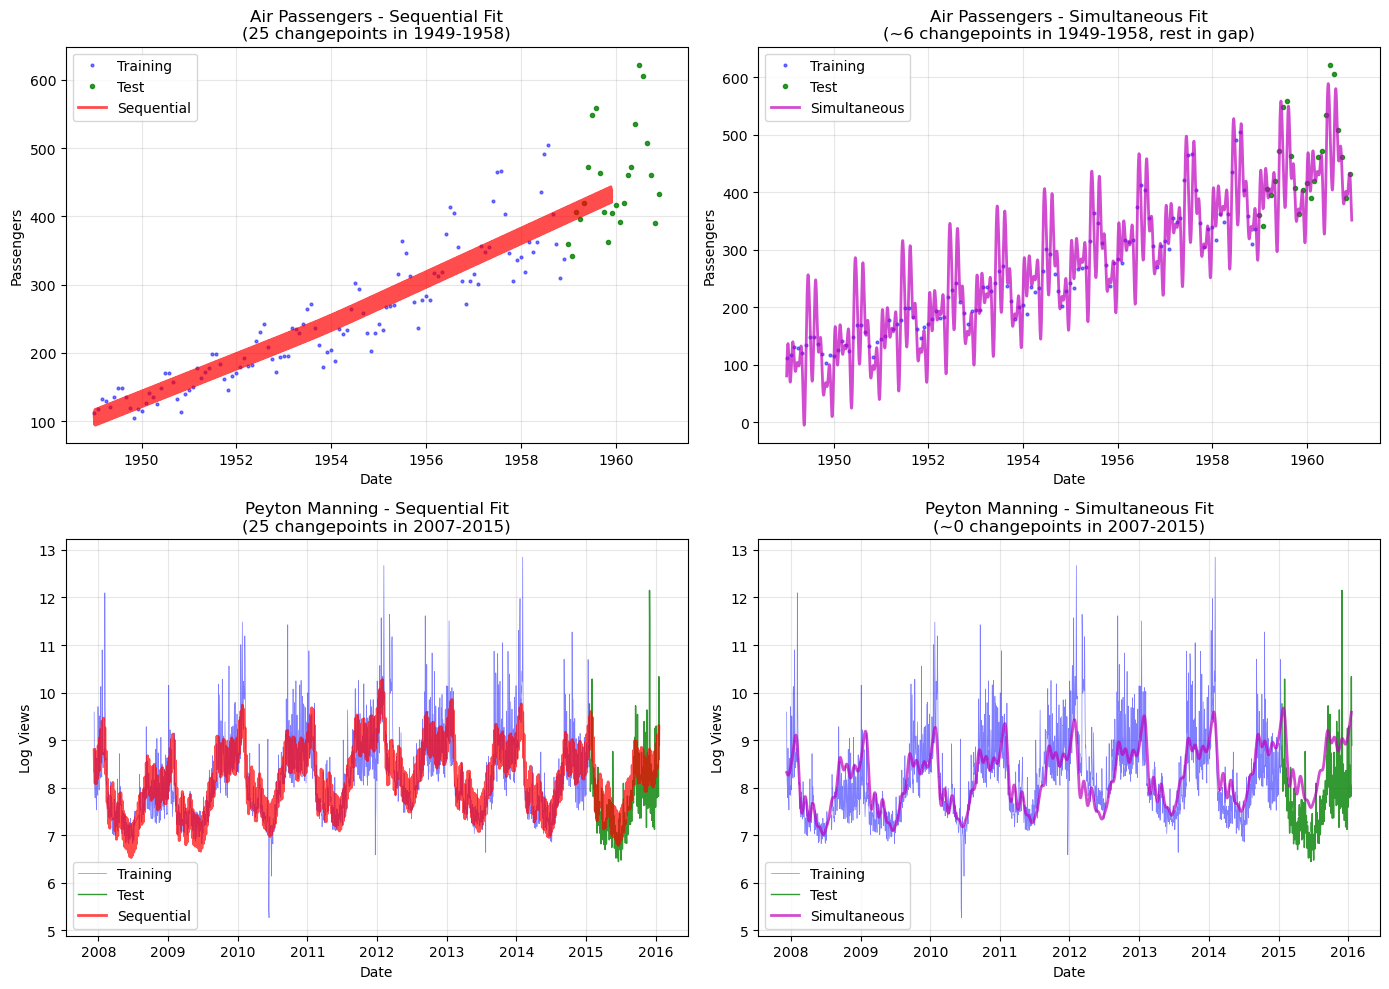

In [ ]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Air Passengers
ax = axes[0, 0]
ax.plot(
    train_passengers["ds"],
    train_passengers["y"],
    "b.",
    markersize=4,
    alpha=0.5,
    label="Training",
)
ax.plot(
    test_passengers["ds"],
    test_passengers["y"],
    "g.",
    markersize=6,
    alpha=0.8,
    label="Test",
)
ax.plot(
    future_passengers_seq["ds"],
    future_passengers_seq["yhat_0"],
    "r-",
    linewidth=2,
    alpha=0.7,
    label="Sequential",
)
ax.set_title("Air Passengers - Sequential Fit\n(25 changepoints in 1949-1958)")
ax.set_xlabel("Date")
ax.set_ylabel("Passengers")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(
    train_passengers["ds"],
    train_passengers["y"],
    "b.",
    markersize=4,
    alpha=0.5,
    label="Training",
)
ax.plot(
    test_passengers["ds"],
    test_passengers["y"],
    "g.",
    markersize=6,
    alpha=0.8,
    label="Test",
)
ax.plot(
    future_passengers_combined["ds"],
    future_passengers_combined[f"yhat_{passengers_group}"],
    "m-",
    linewidth=2,
    alpha=0.7,
    label="Simultaneous",
)
ax.set_title(
    f"Air Passengers - Simultaneous Fit\n(~{cp_in_ap} changepoints in 1949-1958, rest in gap)"
)
ax.set_xlabel("Date")
ax.set_ylabel("Passengers")
ax.legend()
ax.grid(True, alpha=0.3)

# Peyton Manning
ax = axes[1, 0]
ax.plot(
    train_peyton["ds"],
    train_peyton["y"],
    "b-",
    linewidth=0.5,
    alpha=0.5,
    label="Training",
)
ax.plot(test_peyton["ds"], test_peyton["y"], "g-", linewidth=1, alpha=0.8, label="Test")
ax.plot(
    future_peyton_seq["ds"],
    future_peyton_seq["yhat_0"],
    "r-",
    linewidth=2,
    alpha=0.7,
    label="Sequential",
)
ax.set_title("Peyton Manning - Sequential Fit\n(25 changepoints in 2007-2015)")
ax.set_xlabel("Date")
ax.set_ylabel("Log Views")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(
    train_peyton["ds"],
    train_peyton["y"],
    "b-",
    linewidth=0.5,
    alpha=0.5,
    label="Training",
)
ax.plot(test_peyton["ds"], test_peyton["y"], "g-", linewidth=1, alpha=0.8, label="Test")
ax.plot(
    future_peyton_combined["ds"],
    future_peyton_combined["yhat_0"],
    "m-",
    linewidth=2,
    alpha=0.7,
    label="Simultaneous",
)
ax.set_title(
    f"Peyton Manning - Simultaneous Fit\n(~{cp_in_pm} changepoints in 2007-2015)"
)
ax.set_xlabel("Date")
ax.set_ylabel("Log Views")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Summary and Recommendations

### Key Findings

1. **Different results are expected**: When series have very different date ranges, simultaneous and sequential fitting will produce different results due to changepoint distribution.

2. **Changepoint dilution**: With a ~60-year combined time range but each series only covering ~10 years, each series only gets a fraction of the specified changepoints.

3. **This is not a bug**: This is expected behavior. Changepoints are placed in normalized time `t = [0, 1]`, which spans the entire combined date range.

### Recommendations

| Scenario | Recommendation |
|----------|----------------|
| Series with same time range | ✅ Use simultaneous fitting (see Chapter 03) |
| Series with overlapping time ranges | ✅ Simultaneous fitting works well |
| Series with non-overlapping ranges | ⚠️ Consider sequential fitting |
| Series with large time gaps | ❌ Fit separately for best results |

### Workarounds

If you must fit series with different date ranges simultaneously:

1. **Increase `n_changepoints`**: Compensate for dilution by increasing the total number of changepoints
2. **Group similar series**: Fit series with similar date ranges together
3. **Use hierarchical pooling**: Consider `pool_type="partial"` to share information across series while maintaining flexibility
4. **Filter predictions**: Always use `filter_predictions_by_series()` to get the correct date range for each series

### Utility Functions

```python
# Filter predictions to a specific series' date range
from vangja.utils import filter_predictions_by_series

filtered_predictions = filter_predictions_by_series(
    future=predictions,          # Full predictions DataFrame
    series_data=train_data,      # Training data for the series
    yhat_col="yhat_0",          # Prediction column name
    horizon=365                  # Forecast horizon
)
```